In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

project_root = os.path.abspath('../../../')
project = 'fvcom'

In [2]:
u = np.load(f'{project_root}/data/{project}/u_interp.npy') 
v = np.load(f'{project_root}/data/{project}/v_interp.npy')
t = np.load(f'{project_root}/data/{project}/t.npy')
reference_date = pd.Timestamp("2005-01-01")
datetimes = [reference_date + pd.to_timedelta(days - 732313.0, unit='D') for days in t]

In [3]:
for dtidx in datetimes[:10]:
	print(dtidx[0].strftime('%Y-%m-%d %H:%M:%S'))

2005-01-01 00:00:00
2005-01-01 04:58:07
2005-01-01 10:01:52
2005-01-01 15:00:00
2005-01-01 19:58:07
2005-01-02 01:01:52
2005-01-02 06:00:00
2005-01-02 10:58:07
2005-01-02 16:01:52
2005-01-02 21:00:00


In [4]:
nt = len(datetimes)
dt_seconds = np.array([(dt[0] - datetimes[0][0]).total_seconds() for dt in datetimes])

print("Average dt (hours):", np.mean(np.diff(dt_seconds)) / 3600)
print("Min dt (hours):", np.min(np.diff(dt_seconds)) / 3600)

Average dt (hours): 5.09751841799147
Min dt (hours): 4.96875


Autocorrelation of |$u$| drops to 1/e at t = 12416.96 seconds (3.45 hours)
Integral timescale of |$u$|: 49533.52 seconds (13.76 hours)
Autocorrelation drops below 0 at t = 594000.00 seconds (165.00 hours)
Autocorrelation of |$v$| drops to 1/e at t = 16800.31 seconds (4.67 hours)
Integral timescale of |$v$|: 133941.54 seconds (37.21 hours)
Autocorrelation drops below 0 at t = 1853887.50 seconds (514.97 hours)


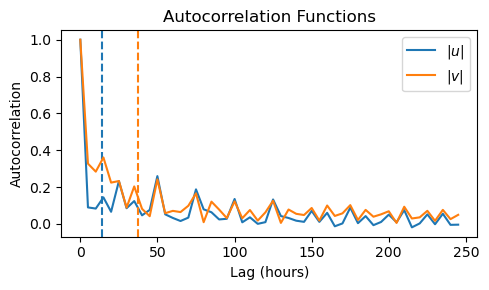

In [6]:

fields = {
    '|$u$|': (u, 'u_mean_t', 'autocorr_u', 'tau_e_u'),
    '|$v$|': (v, 'v_mean_t', 'autocorr_v', 'tau_e_v'),
}

results = {}
plt.figure(figsize=(5, 3))

for label, (arr, mean_name, ac_name, tau_name) in fields.items():
    mean_t = np.nanmean(np.abs(arr), axis=(1,2))
    mean_t -= np.nanmean(mean_t)
    mean_t /= np.nanstd(mean_t)
    autocorr = np.correlate(mean_t, mean_t, mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    autocorr /= autocorr[0]
    lags_pos = dt_seconds[:len(autocorr)]
    tau_e = np.interp(1/np.e, autocorr[::-1], lags_pos[::-1])
    # Integral timescale: area under autocorr until first zero crossing
    zero_cross = np.where(autocorr < 0)[0]
    if len(zero_cross) > 0:
        idx = zero_cross[0]
        int_tau = np.trapz(autocorr[:idx], lags_pos[:idx])
    else:
        int_tau = np.trapz(autocorr, lags_pos)
    results[label] = (autocorr, tau_e)
    print(f"Autocorrelation of {label} drops to 1/e at t = {tau_e:.2f} seconds ({tau_e/3600:.2f} hours)")
    print(f"Integral timescale of {label}: {int_tau:.2f} seconds ({int_tau/3600:.2f} hours)")
    if len(zero_cross) > 0:
        print(f"Autocorrelation drops below 0 at t = {lags_pos[idx]:.2f} seconds ({lags_pos[idx]/3600:.2f} hours)")
    p1 = plt.plot(lags_pos[:50] / 3600, autocorr[:50], label=label)
    plt.axvline(int_tau / 3600, color=p1[0].get_color(), linestyle='--')

plt.xlabel('Lag (hours)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Functions')
plt.legend()
plt.tight_layout()
plt.savefig(f'{project_root}/figures/{project}/bo/fvcom_autocorr_characteristic_timescales.png', dpi=300, bbox_inches='tight')
plt.show()
